In [15]:
import joblib

data_records = joblib.load("data_records.pkl")

In [16]:
import numpy as np


# Define a function to assign labels based on fat percentage ranges
def assign_label(fat_percent):
    if fat_percent <= 5:
        return 0  # Label for fat percentage range 0-5
    elif fat_percent <= 33:
        return 1  # Label for fat percentage range 5-33
    elif fat_percent <= 66:
        return 2  # Label for fat percentage range 33-66
    else:
        return 3  # Label for fat percentage >66

In [17]:
def create_rgb(image):
    return np.stack((image,) * 3, axis=-1)

In [18]:
data_records['grade'] = np.vectorize(assign_label)(data_records['fat'])

In [19]:
X = data_records["images"]
X = np.array([create_rgb(img) for img in X])

y = np.array(data_records['grade'])

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
def display_conf_matrix(conf_matrix):
    # Plot the confusion matrix
    class_names = ["Grade 1", "Grade 2", "Grade 3", "Grade 4"]
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        conf_matrix,
        annot=True,
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


In [42]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score

def display_pred_results(model, X_test, y_test):
    y_pred = model.predict(X_test)

    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)

    conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

    class_report = classification_report(y_true_labels, y_pred_labels)

    accuracy = accuracy_score(y_true_labels, y_pred_labels)

    # auc = roc_auc_score(y_true_labels, y_pred_labels)
    print("\nPrecision score", precision_score(y_true_labels, y_pred_labels, average="weighted"))

    recall = recall_score(y_true_labels, y_pred_labels, average="weighted")
    print("\nRecall:", recall)

    f1 = f1_score(y_true_labels, y_pred_labels, average="weighted")
    print("\nF1 score: ", f1)

    print("\nClassification Report:")
    print(class_report)
    print("\nAccuracy:", accuracy)
    display_conf_matrix(conf_matrix)

## model 1: normal, 0.66 tr, no adam opt or early stopping

In [ ]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42, stratify=y
)

In [ ]:
print(X_train[0].shape)

In [ ]:
from sklearn import preprocessing
import tensorflow as tf


le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)

y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)

y_train = np.array(y_train)
X_train = np.array(X_train)
y_test = np.array(y_test)
X_test = np.array(X_test)

In [ ]:
X_test.shape

In [ ]:
from keras.applications import vgg16

img_rows, img_cols = (400, 630)

vgg = vgg16.VGG16(
    weights="imagenet", include_top=False, input_shape=(img_rows, img_cols, 3)
)

In [ ]:
# Here we freeze the last 4 layers
# Layers are set to trainable as True by default
for layer in vgg.layers:
    layer.trainable = False

# Let's print our layers
for i, layer in enumerate(vgg.layers):
    print(str(i) + " " + layer.__class__.__name__, layer.trainable)

In [ ]:
from keras.layers import Dense, GlobalAveragePooling2D


def lw(bottom_model, num_classes):

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation="relu")(top_model)
    top_model = Dense(1024, activation="relu")(top_model)
    top_model = Dense(512, activation="relu")(top_model)
    top_model = Dense(num_classes, activation="softmax")(top_model)
    return top_model

In [ ]:
from keras.models import Model


num_classes = 4

FC_Head = lw(vgg, num_classes)

model = Model(inputs=vgg.input, outputs=FC_Head)

print(model.summary())

In [ ]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    X_train,
    y_train,
    epochs=5,
    validation_data=(X_test, y_test),
    verbose=1,
    initial_epoch=0,
)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Get predictions on test data
y_pred = model.predict(X_test)

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Compute classification report
class_report = classification_report(y_true_labels, y_pred_labels)

# Compute accuracy
accuracy = accuracy_score(y_true_labels, y_pred_labels)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)
print("\nAccuracy:", accuracy)


## model 2: 0.8 tr, no early stopping

In [ ]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
from sklearn import preprocessing
import tensorflow as tf


le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)

y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)

y_train = np.array(y_train)
X_train = np.array(X_train)
y_test = np.array(y_test)
X_test = np.array(X_test)

In [ ]:
from keras.applications import vgg16

img_rows, img_cols = (400, 630)

vgg = vgg16.VGG16(
    weights="imagenet", include_top=False, input_shape=(img_rows, img_cols, 3)
)

In [ ]:
# Here we freeze the last 4 layers
# Layers are set to trainable as True by default
for layer in vgg.layers:
    layer.trainable = False

# Let's print our layers
for i, layer in enumerate(vgg.layers):
    print(str(i) + " " + layer.__class__.__name__, layer.trainable)

In [ ]:
from keras.layers import Dense, GlobalAveragePooling2D


def lw(bottom_model, num_classes):

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation="relu")(top_model)
    top_model = Dense(1024, activation="relu")(top_model)
    top_model = Dense(512, activation="relu")(top_model)
    top_model = Dense(num_classes, activation="softmax")(top_model)
    return top_model

In [ ]:
from keras.models import Model


num_classes = 4

FC_Head = lw(vgg, num_classes)

model = Model(inputs=vgg.input, outputs=FC_Head)

print(model.summary())

In [ ]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    X_train,
    y_train,
    epochs=5,
    validation_data=(X_test, y_test),
    verbose=1,
    initial_epoch=0,
)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Get predictions on test data
y_pred = model.predict(X_test)

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Compute classification report
class_report = classification_report(y_true_labels, y_pred_labels)

# Compute accuracy
accuracy = accuracy_score(y_true_labels, y_pred_labels)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)
print("\nAccuracy:", accuracy)


In [ ]:
model.layers

## model 3: remove a layer for fun; didn't work out

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow as tf
from keras.applications import vgg16
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)



le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)

y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)

y_train = np.array(y_train)
X_train = np.array(X_train)
y_test = np.array(y_test)
X_test = np.array(X_test)


img_rows, img_cols = (400, 630)

vgg = vgg16.VGG16(
    weights="imagenet", include_top=False, input_shape=(img_rows, img_cols, 3)
)


for layer in vgg.layers:
    layer.trainable = False

for i, layer in enumerate(vgg.layers):
    print(str(i) + " " + layer.__class__.__name__, layer.trainable)



def lw(bottom_model, num_classes):

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    # top_model = Dense(1024, activation="relu")(top_model)
    top_model = Dense(1024, activation="relu")(top_model)
    top_model = Dense(512, activation="relu")(top_model)
    top_model = Dense(num_classes, activation="softmax")(top_model)
    return top_model




num_classes = 4

FC_Head = lw(vgg, num_classes)

model = Model(inputs=vgg.input, outputs=FC_Head)

print(model.summary())

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    X_train,
    y_train,
    epochs=5,
    validation_data=(X_test, y_test),
    verbose=1,
    initial_epoch=0,
)

## model 4: 0.8 tr, early stopping, lr=0.001(default)

In [22]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow as tf
import numpy as np
from keras.applications import vgg16
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# Preprocess the labels
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

# One-hot encode the labels
num_classes = 4
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

img_rows, img_cols = (400, 630)
base_model = vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(img_rows, img_cols, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dense(1024, activation="relu")(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = Adam(learning_rate=0.001)  # Adjust learning rate as needed
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    epochs=20,  # Increase epochs if needed
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stopping]
)


Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 210s 15s/step - accuracy: 0.3274 - loss: 2.3667 - val_accuracy: 0.3636 - val_loss: 1.3038
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 208s 15s/step - accuracy: 0.4260 - loss: 1.2807 - val_accuracy: 0.3636 - val_loss: 1.2474
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 130s 9s/step - accuracy: 0.4337 - loss: 1.1559 - val_accuracy: 0.5455 - val_loss: 1.0586
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 131s 9s/step - accuracy: 0.5490 - loss: 1.0779 - val_accuracy: 0.5818 - val_loss: 0.9483
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 131s 10s/step - accuracy: 0.6266 - loss: 0.9140 - val_accuracy: 0.5727 - val_loss: 0.8437
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 153s 11s/step - accuracy: 0.6943 - loss: 0.7724 - val_accuracy: 0.6364 - val_loss: 0.7832
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 251s 19s/step - accuracy: 0.7073 - loss: 0.6851 - val_accuracy: 0.6636 - val_loss: 0.8899
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 284s 21s/step - accuracy: 0.7324 - loss: 0.6319 - val_accuracy: 0.71

6/6 ━━━━━━━━━━━━━━━━━━━━ 39s 7s/step
Confusion Matrix:
[[54  0  4  0]
 [ 6 50  8  0]
 [ 0  0 22  0]
 [ 1  0 11 27]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91        58
           1       1.00      0.78      0.88        64
           2       0.49      1.00      0.66        22
           3       1.00      0.69      0.82        39

    accuracy                           0.84       183
   macro avg       0.84      0.85      0.81       183
weighted avg       0.90      0.84      0.85       183


Accuracy: 0.8360655737704918


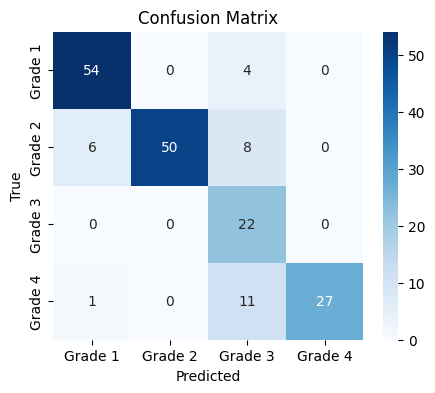

In [45]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Get predictions on test data
y_pred = model.predict(X_test)

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Compute classification report
class_report = classification_report(y_true_labels, y_pred_labels)

# Compute accuracy
accuracy = accuracy_score(y_true_labels, y_pred_labels)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)
print("\nAccuracy:", accuracy)
display_conf_matrix(conf_matrix)

In [28]:
model.save(r"..\models\vgg16\vgg_best.keras")

6/6 ━━━━━━━━━━━━━━━━━━━━ 40s 7s/step

Precision score 0.9021847969980192

Recall: 0.8360655737704918

F1 score:  0.8477369313797738

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91        58
           1       1.00      0.78      0.88        64
           2       0.49      1.00      0.66        22
           3       1.00      0.69      0.82        39

    accuracy                           0.84       183
   macro avg       0.84      0.85      0.81       183
weighted avg       0.90      0.84      0.85       183


Accuracy: 0.8360655737704918


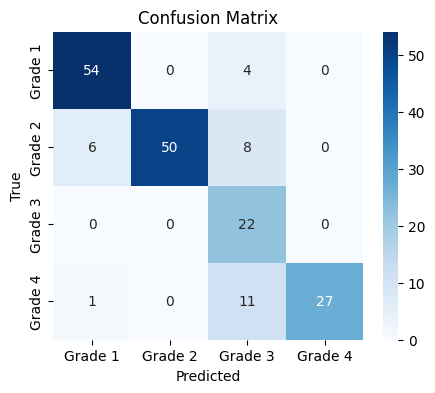

In [44]:
new_model = tf.keras.models.load_model("..\\models\\vgg16\\vgg_best.keras")

display_pred_results(new_model, X_test, y_test)


## m5: 0.8 tr, early stopping, data augmentation (shear, rotate, flip), lr=0.001

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow as tf
import numpy as np
from keras.applications import vgg16
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

num_classes = 4
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

# Load pre-trained VGG16 model
img_rows, img_cols = (400, 630)
base_model = vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(img_rows, img_cols, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add custom dense layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dense(1024, activation="relu")(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(num_classes, activation="softmax")(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with Adam optimizer and categorical crossentropy loss
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the model with data augmentation and early stopping
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    steps_per_epoch=len(X_train) / 32,
    epochs=20,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)


In [ ]:
import joblib as jb
jb.dump(model, "..\models\\vgg16_data_aug.pkl")

## m6: 0.8 tr, lr=0.003, no data aug

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 121s 9s/step - accuracy: 0.2204 - loss: 3.0933 - val_accuracy: 0.3273 - val_loss: 1.3096
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 140s 10s/step - accuracy: 0.3537 - loss: 1.3488 - val_accuracy: 0.5818 - val_loss: 1.1776
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 147s 11s/step - accuracy: 0.5381 - loss: 1.1420 - val_accuracy: 0.5545 - val_loss: 1.0450
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 262s 19s/step - accuracy: 0.4945 - loss: 1.1129 - val_accuracy: 0.6455 - val_loss: 0.8704
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 134s 9s/step - accuracy: 0.5618 - loss: 0.9708 - val_accuracy: 0.6455 - val_loss: 0.7679
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 130s 9s/step - accuracy: 0.6186 - loss: 0.8671 - val_accuracy: 0.6727 - val_loss: 0.7859
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 130s 9s/step - accuracy: 0.6701 - loss: 0.7292 - val_accuracy: 0.6545 - val_loss: 0.7110
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 129s 9s/step - accuracy: 0.7343 - loss: 0.6837 - val_accuracy: 0.5182 

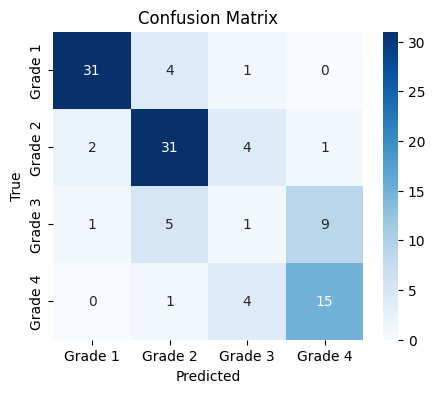

In [13]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow as tf
from keras.applications import vgg16
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# Preprocess the labels
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

# One-hot encode the labels
num_classes = 4
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

img_rows, img_cols = (400, 630)
base_model = vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(img_rows, img_cols, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dense(1024, activation="relu")(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = Adam(learning_rate=0.003)  # Adjust learning rate as needed
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    epochs=20,  # Increase epochs if needed
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stopping]
)
display_pred_results(model, X_test, y_test)


In [18]:
model.save("..\models\\vgg16\\lr_0_003.keras")

## m7: 0.8 tr, lr=0.01, early stopping

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 247s 18s/step - accuracy: 0.2788 - loss: 30.4097 - val_accuracy: 0.3273 - val_loss: 1.3636
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 162s 11s/step - accuracy: 0.3781 - loss: 1.2757 - val_accuracy: 0.5182 - val_loss: 1.1377
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 129s 9s/step - accuracy: 0.4567 - loss: 1.1633 - val_accuracy: 0.5364 - val_loss: 1.1303
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 129s 9s/step - accuracy: 0.5334 - loss: 1.1016 - val_accuracy: 0.4364 - val_loss: 1.0534
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 129s 9s/step - accuracy: 0.4697 - loss: 1.0696 - val_accuracy: 0.5818 - val_loss: 0.9460
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 129s 9s/step - accuracy: 0.5206 - loss: 1.0245 - val_accuracy: 0.5273 - val_loss: 0.9979
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 129s 9s/step - accuracy: 0.5799 - loss: 0.8645 - val_accuracy: 0.5909 - val_loss: 0.8775
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 129s 9s/step - accuracy: 0.6656 - loss: 0.8129 - val_accuracy: 0.6727 

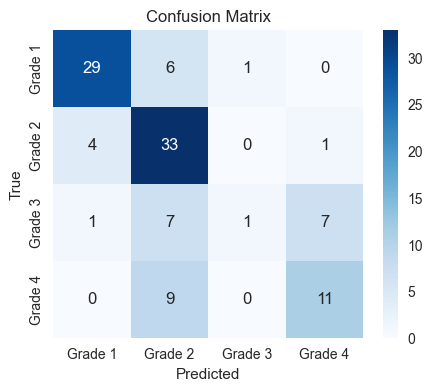

In [24]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow as tf
from keras.applications import vgg16
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

# One-hot encode the labels
num_classes = 4
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

img_rows, img_cols = (400, 630)
base_model = vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(img_rows, img_cols, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dense(1024, activation="relu")(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = Adam(learning_rate=0.01)  
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    epochs=20,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stopping]
)
display_pred_results(model, X_test, y_test)

## m7: 0.8 tr, lr=0.002

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 258s 19s/step - accuracy: 0.3270 - loss: 3.8763 - val_accuracy: 0.3455 - val_loss: 1.2680
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 268s 19s/step - accuracy: 0.3522 - loss: 1.2453 - val_accuracy: 0.4909 - val_loss: 1.1045
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 148s 10s/step - accuracy: 0.4839 - loss: 1.1335 - val_accuracy: 0.4000 - val_loss: 1.1661
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 133s 10s/step - accuracy: 0.4439 - loss: 1.1085 - val_accuracy: 0.5818 - val_loss: 0.9924
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 133s 10s/step - accuracy: 0.6005 - loss: 0.9614 - val_accuracy: 0.5000 - val_loss: 0.9605
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 133s 10s/step - accuracy: 0.6188 - loss: 0.8954 - val_accuracy: 0.5727 - val_loss: 0.8422
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 133s 10s/step - accuracy: 0.6110 - loss: 0.7837 - val_accuracy: 0.6636 - val_loss: 0.7607
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 288s 21s/step - accuracy: 0.7459 - loss: 0.6047 - val_accuracy: 0.

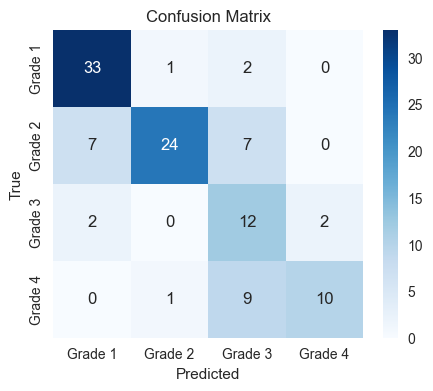

In [25]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow as tf
from keras.applications import vgg16
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

# One-hot encode the labels
num_classes = 4
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

img_rows, img_cols = (400, 630)
base_model = vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(img_rows, img_cols, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dense(1024, activation="relu")(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = Adam(learning_rate=0.002)  
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    epochs=20,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stopping]
)
display_pred_results(model, X_test, y_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step

Precision score 0.7857209457209458

Recall: 0.7181818181818181

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        36
           1       0.92      0.63      0.75        38
           2       0.40      0.75      0.52        16
           3       0.83      0.50      0.62        20

    accuracy                           0.72       110
   macro avg       0.74      0.70      0.69       110
weighted avg       0.79      0.72      0.73       110


Accuracy: 0.7181818181818181


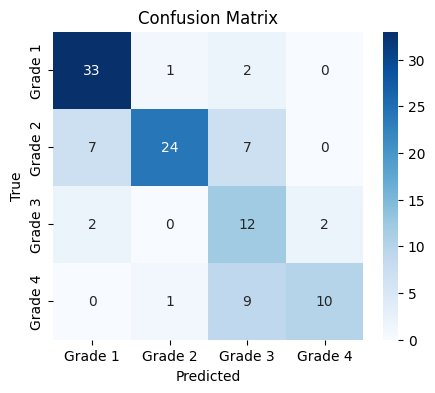

In [38]:
new_model = tf.keras.models.load_model("..\\models\\vgg16\\lr_0_002.keras")

display_pred_results(new_model, X_test, y_test)


In [28]:
model.save( "..\\models\\vgg16\\lr_0_002.keras")

## m8: lr=0.0008

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 495s 37s/step - accuracy: 0.3171 - loss: 1.9751 - val_accuracy: 0.3909 - val_loss: 1.3081
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 378s 26s/step - accuracy: 0.4176 - loss: 1.2023 - val_accuracy: 0.5000 - val_loss: 1.1687
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 335s 24s/step - accuracy: 0.5641 - loss: 1.0832 - val_accuracy: 0.5455 - val_loss: 0.9796
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 336s 24s/step - accuracy: 0.5613 - loss: 0.9515 - val_accuracy: 0.6000 - val_loss: 0.8809
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1819s 138s/step - accuracy: 0.6457 - loss: 0.8562 - val_accuracy: 0.5000 - val_loss: 1.0620
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 197s 14s/step - accuracy: 0.6393 - loss: 0.8014 - val_accuracy: 0.5909 - val_loss: 0.8418
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 255s 19s/step - accuracy: 0.7691 - loss: 0.6402 - val_accuracy: 0.6909 - val_loss: 0.8071
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 253s 18s/step - accuracy: 0.6897 - loss: 0.6714 - val_accuracy: 

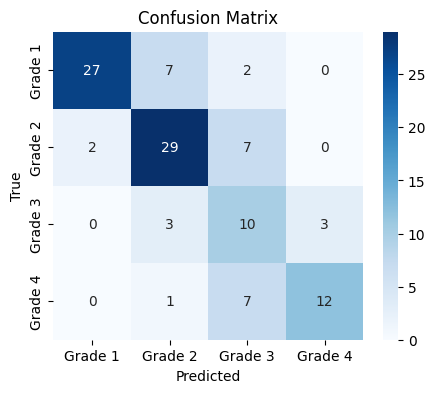

In [10]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow as tf
from keras.applications import vgg16
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

# One-hot encode the labels
num_classes = 4
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

img_rows, img_cols = (400, 630)
base_model = vgg16.VGG16(
    weights="imagenet", include_top=False, input_shape=(img_rows, img_cols, 3)
)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dense(1024, activation="relu")(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = Adam(learning_rate=0.0008)
model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

early_stopping = EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)

history = model.fit(
    X_train,
    y_train,
    epochs=20,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stopping],
)
display_pred_results(model, X_test, y_test)

In [10]:
from sklearn import preprocessing
import tensorflow as tf
from keras.applications import vgg16
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
num_classes = 4

accuracy_scores = []
loss_scores = []

img_rows, img_cols = (400, 630)
base_model = vgg16.VGG16(
    weights="imagenet", include_top=False, input_shape=(img_rows, img_cols, 3)
)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dense(1024, activation="relu")(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    le = preprocessing.LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.fit_transform(y_test)

    # One-hot encode the labels
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

    history = model.fit(
        X_train,
        y_train,
        epochs=5,
        validation_data=(X_test, y_test),
        verbose=1,
    )

    scores = model.evaluate(X_test, y_test, verbose=0)
    accuracy_scores.append(scores[1])  # Accuracy score
    loss_scores.append(scores[0])

    avg_acc = np.mean(accuracy_scores)
    avg_loss = np.mean(loss_scores)
    print(scores)
# display_pred_results(model, X_test, y_test)

Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 123s 11s/step - accuracy: 0.2867 - loss: 1.9468 - val_accuracy: 0.4239 - val_loss: 1.4432
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 129s 11s/step - accuracy: 0.3674 - loss: 1.3201 - val_accuracy: 0.5435 - val_loss: 1.2216
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 129s 11s/step - accuracy: 0.4623 - loss: 1.1529 - val_accuracy: 0.4402 - val_loss: 1.1828
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 238s 21s/step - accuracy: 0.5028 - loss: 1.0988 - val_accuracy: 0.5109 - val_loss: 1.0204
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 237s 20s/step - accuracy: 0.5367 - loss: 0.9982 - val_accuracy: 0.4891 - val_loss: 0.9824
[0.982387125492096, 0.489130437374115]
Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 163s 14s/step - accuracy: 0.5905 - loss: 0.8814 - val_accuracy: 0.6339 - val_loss: 0.8040
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 217s 18s/step - accuracy: 0.6669 - loss: 0.7839 - val_accuracy: 0.6776 - val_loss: 0.7610
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 129s 11s/step - accuracy: 0.7316 - 

In [14]:

avg_acc = np.mean(accuracy_scores)
avg_loss = np.mean(loss_scores)

print(avg_acc)
print(avg_loss)

0.665775716304779
0.7331745227177938


# Cross validation

In [47]:
import numpy as np
import tensorflow as tf
from keras.applications import vgg16
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing

# # Prepare your data
# X = np.array(data_records["image"])  # Assuming these are image datasets
# y = np.array(data_records["grade"])  # Assuming these are the corresponding labels

# Encode labels
le = preprocessing.LabelEncoder()
y_encoded = le.fit_transform(y)

# One-hot encode the labels
num_classes = 4
y_categorical = tf.keras.utils.to_categorical(y_encoded, num_classes=num_classes)

# Setup cross-validation
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # 5-fold cross-validation
all_histories = []  # Store histories for each fold
fold_no = 1

# Create a VGG16-based model
img_rows, img_cols = (400, 630)
base_model = vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(img_rows, img_cols, 3))

# Make all layers non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Build the model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dense(1024, activation="relu")(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile and train the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


for train_idx, test_idx in kf.split(X, y):
    print(f"Training fold {fold_no}")

    # Split the data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y_categorical[train_idx], y_categorical[test_idx]

    

    # Train the model for this fold
    history = model.fit(
        X_train,
        y_train,
        epochs=10,
        validation_data=(X_test, y_test),
        verbose=1,
        callbacks=[early_stopping]
    )

    all_histories.append(history)  # Store the history for this fold
    fold_no += 1


Training fold 1
Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 126s 11s/step - accuracy: 0.3404 - loss: 2.2959 - val_accuracy: 0.3533 - val_loss: 1.2662
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 129s 11s/step - accuracy: 0.3903 - loss: 1.2201 - val_accuracy: 0.4511 - val_loss: 1.1366
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 129s 11s/step - accuracy: 0.5102 - loss: 1.0951 - val_accuracy: 0.6141 - val_loss: 1.0233
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 129s 11s/step - accuracy: 0.5019 - loss: 1.0666 - val_accuracy: 0.6196 - val_loss: 0.9696
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 176s 15s/step - accuracy: 0.6069 - loss: 0.8967 - val_accuracy: 0.5870 - val_loss: 0.8487
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 290s 25s/step - accuracy: 0.6675 - loss: 0.7944 - val_accuracy: 0.6304 - val_loss: 0.7767
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 290s 25s/step - accuracy: 0.7280 - loss: 0.7344 - val_accuracy: 0.6467 - val_loss: 0.7018
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 289s 25s/step - accuracy: 0.7296 - loss: 0.6492 - 

6/6 ━━━━━━━━━━━━━━━━━━━━ 40s 7s/step

Precision score 0.9535466612620791

Recall: 0.9508196721311475

F1 score:  0.9507121059591809

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        60
           1       0.91      1.00      0.95        63
           2       0.93      0.96      0.94        26
           3       0.97      0.88      0.92        34

    accuracy                           0.95       183
   macro avg       0.95      0.94      0.95       183
weighted avg       0.95      0.95      0.95       183


Accuracy: 0.9508196721311475


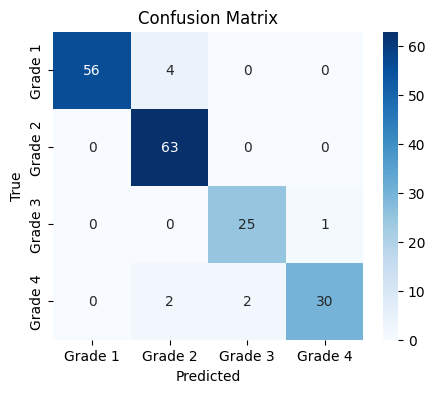

In [48]:
display_pred_results(model, X_test, y_test)


In [50]:
model.save(r"..\models\vgg16\vgg16_best_9508.keras")